<a href="https://colab.research.google.com/github/onurercen/workout_prediction_app/blob/main/DT_Experience_Level.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Tree - Experience Level Prediction

**Standart Ayarlar:** test_size=0.30, random_state=42, cv=5

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
print('Kütüphaneler yüklendi.')

Kütüphaneler yüklendi.


In [2]:
# Veri yükleme
df = pd.read_csv('gym_members_exercise_tracking.csv')
print('='*70)
print('DECISION TREE - EXPERIENCE LEVEL PREDICTION')
print('='*70)
print(f'Veri seti boyutu: {df.shape}')
print(f'Eksik değer: {df.isnull().sum().sum()}')
print(f'\nSütunlar: {list(df.columns)}')

DECISION TREE - EXPERIENCE LEVEL PREDICTION
Veri seti boyutu: (973, 15)
Eksik değer: 0

Sütunlar: ['Age', 'Gender', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)', 'Calories_Burned', 'Workout_Type', 'Fat_Percentage', 'Water_Intake (liters)', 'Workout_Frequency (days/week)', 'Experience_Level', 'BMI']


In [3]:
# Target dağılımı
print('\nExperience Level Dağılımı:')
print(df['Experience_Level'].value_counts().sort_index())


Experience Level Dağılımı:
Experience_Level
1    376
2    406
3    191
Name: count, dtype: int64


In [4]:
# FEATURE ENGINEERING - 15 YENİ FEATURE
print('\n' + '='*70)
print('FEATURE ENGINEERING')
print('='*70)

# Temel 7 feature
df['HR_per_minute'] = df['Avg_BPM'] / (df['Session_Duration (hours)'] * 60)
df['Intensity_per_Weight'] = df['Calories_Burned'] / df['Weight (kg)']
df['HRR'] = df['Max_BPM'] - df['Resting_BPM']
df['Efficiency'] = df['Calories_Burned'] / df['Avg_BPM']
df['Anaerobic_Index'] = (df['Max_BPM'] - df['Avg_BPM']) / df['Resting_BPM']
df['BPM_Variance_Rest'] = (df['Avg_BPM'] - df['Resting_BPM']) ** 2
df['Heart_Instability'] = abs(df['Max_BPM'] - df['Avg_BPM']) / df['Max_BPM']

# Ek feature'lar
df['Calories_per_Hour'] = df['Calories_Burned'] / df['Session_Duration (hours)']
df['Heart_Efficiency'] = df['Calories_Burned'] / df['HRR']
df['BMI_Category'] = pd.cut(df['BMI'], bins=[0, 18.5, 25, 30, 100], labels=[0, 1, 2, 3]).astype(int)
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 25, 35, 45, 100], labels=[0, 1, 2, 3]).astype(int)

# Deneyim seviyesi ile ilgili özel feature'lar
df['Workout_Intensity'] = df['Calories_Burned'] * df['Max_BPM'] / 1000
df['Performance_Score'] = df['Calories_Burned'] * df['Workout_Frequency (days/week)']
df['Fitness_Level'] = df['HRR'] / df['Resting_BPM']
df['Training_Load'] = df['Session_Duration (hours)'] * df['Workout_Frequency (days/week)'] * df['Avg_BPM']

print('15 yeni feature oluşturuldu')


FEATURE ENGINEERING
15 yeni feature oluşturuldu


In [5]:
# Label Encoding
le_gender = LabelEncoder()
le_workout = LabelEncoder()

df['Gender_Encoded'] = le_gender.fit_transform(df['Gender'])
df['Workout_Type_Encoded'] = le_workout.fit_transform(df['Workout_Type'])

print('Encoding tamamlandı.')
print(f"Gender: {dict(zip(le_gender.classes_, range(len(le_gender.classes_))))}")
print(f"Workout: {dict(zip(le_workout.classes_, range(len(le_workout.classes_))))}")

Encoding tamamlandı.
Gender: {'Female': 0, 'Male': 1}
Workout: {'Cardio': 0, 'HIIT': 1, 'Strength': 2, 'Yoga': 3}


In [6]:
# Feature seçimi
feature_cols = [
    'Age', 'Gender_Encoded', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM',
    'Session_Duration (hours)', 'Calories_Burned', 'Workout_Frequency (days/week)',
    'Fat_Percentage', 'Water_Intake (liters)', 'Workout_Type_Encoded', 'BMI',
    'HR_per_minute', 'Intensity_per_Weight', 'HRR', 'Efficiency',
    'Anaerobic_Index', 'BPM_Variance_Rest', 'Heart_Instability',
    'Calories_per_Hour', 'Heart_Efficiency', 'BMI_Category', 'Age_Group',
    'Workout_Intensity', 'Performance_Score', 'Fitness_Level', 'Training_Load'
]

X = df[feature_cols]
y = df['Experience_Level']

print(f'Feature sayısı: {X.shape[1]}')
print(f'Sample sayısı: {X.shape[0]}')

Feature sayısı: 29
Sample sayısı: 973


In [7]:
# TRAIN/TEST SPLIT - STANDART AYARLAR
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

print(f'Train set: {X_train.shape[0]} sample (%70)')
print(f'Test set: {X_test.shape[0]} sample (%30)')
print(f'\nTrain sınıf dağılımı:')
print(y_train.value_counts().sort_index())

Train set: 681 sample (%70)
Test set: 292 sample (%30)

Train sınıf dağılımı:
Experience_Level
1    263
2    284
3    134
Name: count, dtype: int64


In [8]:
# BASELINE MODEL
print('\n' + '='*70)
print('BASELINE MODEL')
print('='*70)

dt_baseline = DecisionTreeClassifier(random_state=42)
dt_baseline.fit(X_train, y_train)

train_acc = accuracy_score(y_train, dt_baseline.predict(X_train))
test_acc = accuracy_score(y_test, dt_baseline.predict(X_test))

print(f'Train Accuracy: {train_acc:.4f}')
print(f'Test Accuracy:  {test_acc:.4f}')
print(f'Overfitting Gap: {train_acc - test_acc:.4f}')
print(f'Ağaç Derinliği: {dt_baseline.get_depth()}')


BASELINE MODEL
Train Accuracy: 1.0000
Test Accuracy:  0.8699
Overfitting Gap: 0.1301
Ağaç Derinliği: 15


In [9]:
# HYPERPARAMETER TUNING
print('\n' + '='*70)
print('HYPERPARAMETER TUNING (GridSearchCV)')
print('='*70)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f'\nEn iyi parametreler: {grid_search.best_params_}')
print(f'En iyi CV skoru: {grid_search.best_score_:.4f}')


HYPERPARAMETER TUNING (GridSearchCV)
Fitting 5 folds for each of 108 candidates, totalling 540 fits

En iyi parametreler: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
En iyi CV skoru: 0.8854


In [10]:
# EN İYİ MODEL
print('\n' + '='*70)
print('OPTİMİZE MODEL PERFORMANSI')
print('='*70)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

train_acc_best = accuracy_score(y_train, best_model.predict(X_train))
test_acc_best = accuracy_score(y_test, y_pred)

print(f'Train Accuracy: {train_acc_best:.4f}')
print(f'Test Accuracy:  {test_acc_best:.4f}')
print(f'Overfitting Gap: {train_acc_best - test_acc_best:.4f}')

print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=['Beginner', 'Intermediate', 'Advanced']))


OPTİMİZE MODEL PERFORMANSI
Train Accuracy: 0.9016
Test Accuracy:  0.9075
Overfitting Gap: -0.0059

Classification Report:
              precision    recall  f1-score   support

    Beginner       0.99      0.77      0.87       113
Intermediate       0.82      0.99      0.90       122
    Advanced       1.00      1.00      1.00        57

    accuracy                           0.91       292
   macro avg       0.94      0.92      0.92       292
weighted avg       0.92      0.91      0.91       292



In [11]:
# CROSS-VALIDATION (Train set üzerinde)
print('\n' + '='*70)
print('CROSS-VALIDATION (5-Fold)')
print('='*70)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='accuracy')

print(f'Fold Scores: {cv_scores}')
print(f'Mean CV: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})')


CROSS-VALIDATION (5-Fold)
Fold Scores: [0.89781022 0.84558824 0.86764706 0.91176471 0.89705882]
Mean CV: 0.8840 (+/- 0.0480)


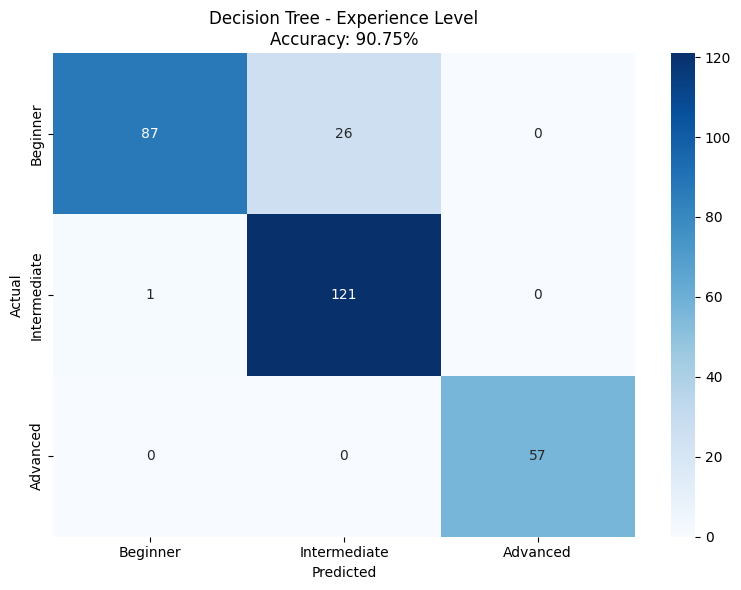

In [12]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Beginner', 'Intermediate', 'Advanced'],
            yticklabels=['Beginner', 'Intermediate', 'Advanced'])
plt.title(f'Decision Tree - Experience Level\nAccuracy: {test_acc_best:.2%}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('dt_exp_confusion_matrix.png', dpi=150)
plt.show()

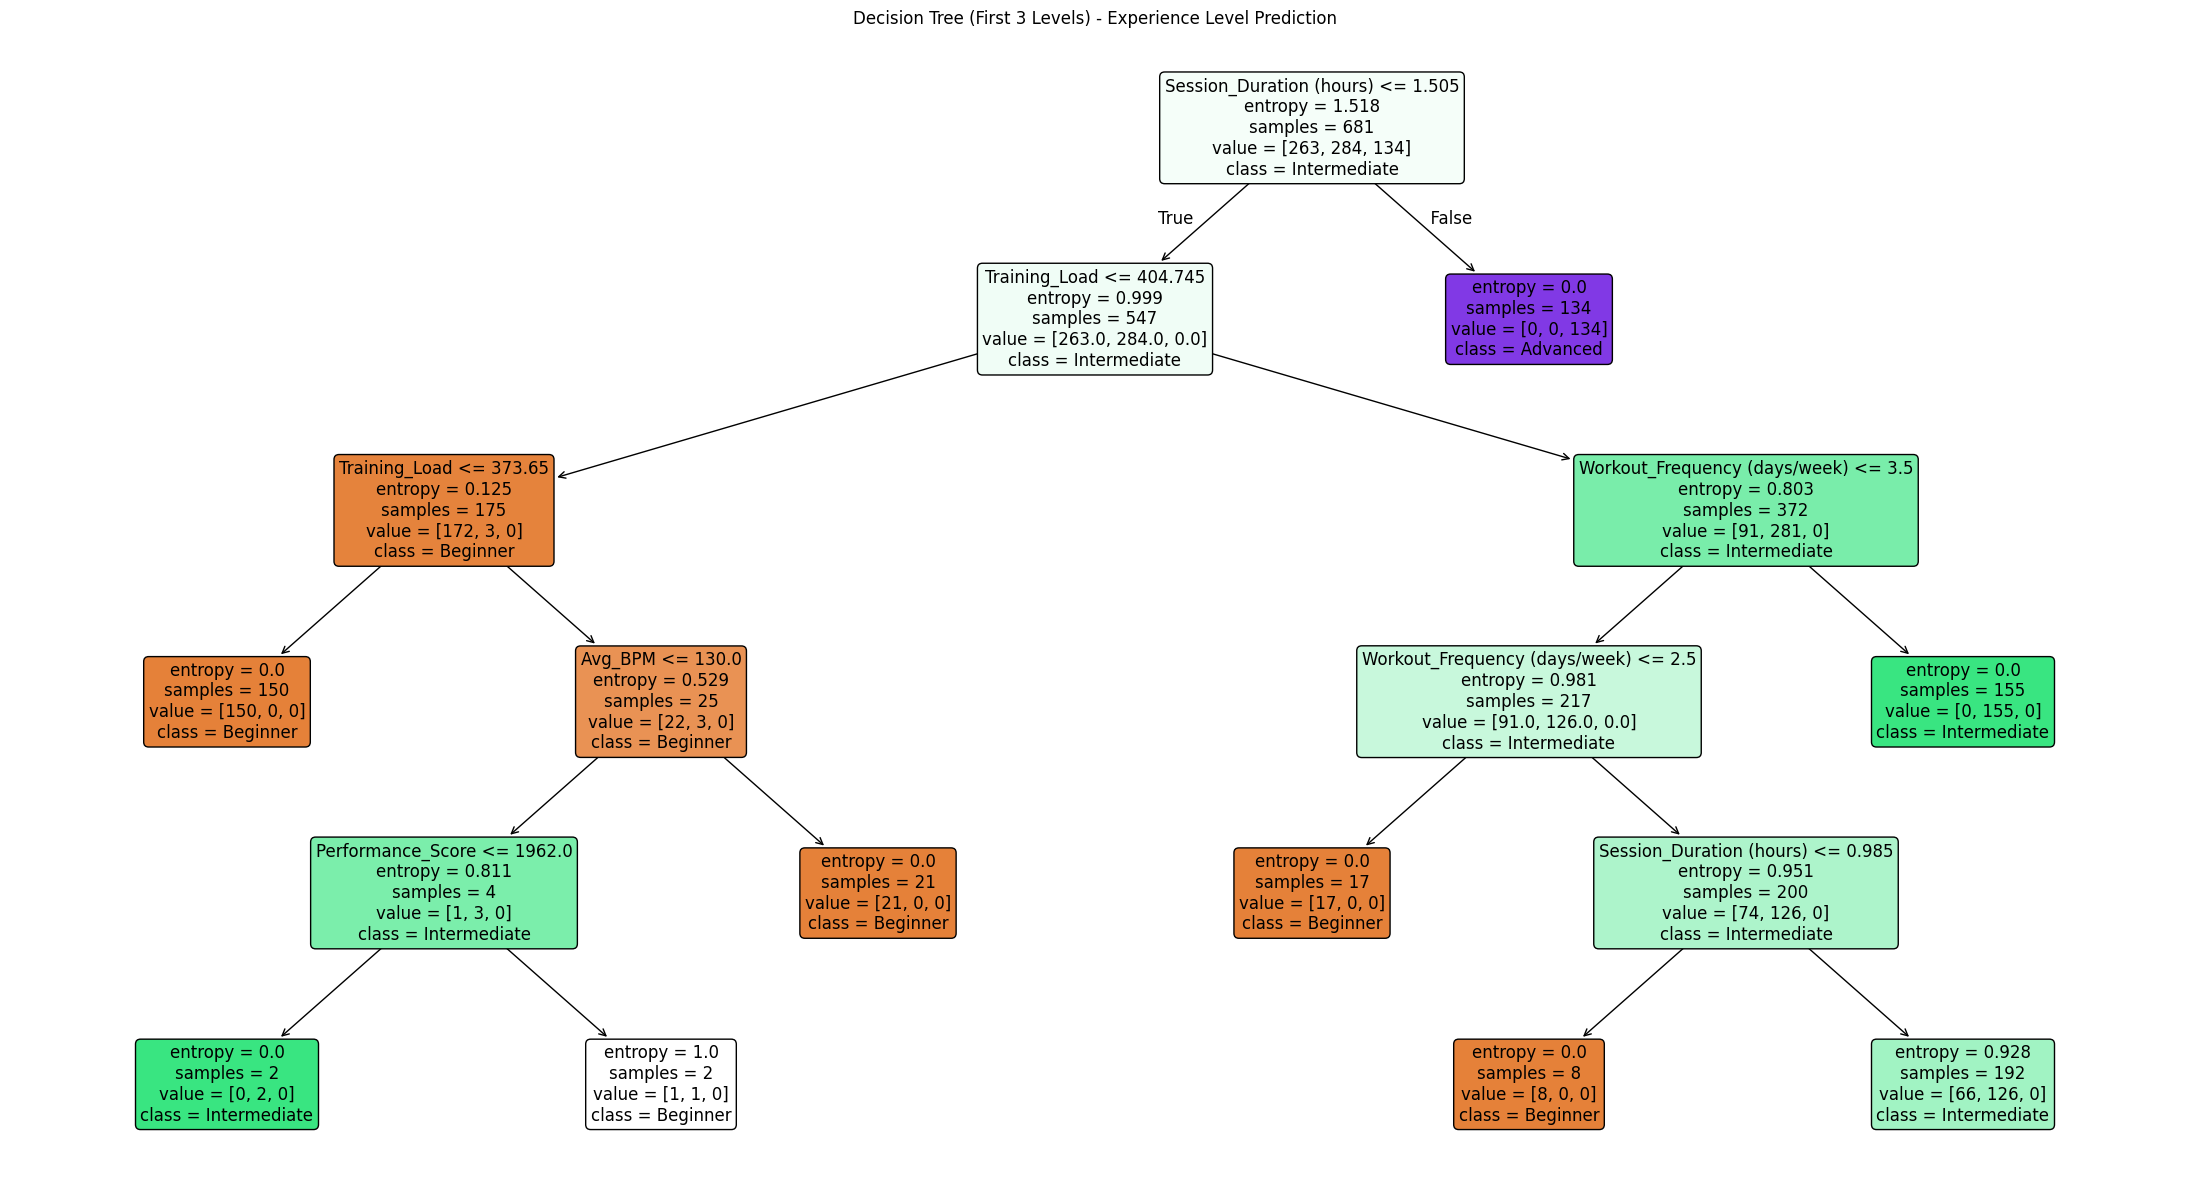

In [16]:
plt.figure(figsize=(22, 12))

plot_tree(
    best_model,
    feature_names=feature_cols,
    class_names=['Beginner', 'Intermediate', 'Advanced'],
    filled=True,
    rounded=True,
    max_depth=5, #SADECE İLK 5 SEVİYE
    fontsize=12
)

plt.title('Decision Tree (First 3 Levels) - Experience Level Prediction')
plt.tight_layout()
plt.savefig('dt_experience_tree.png', dpi=200)
plt.show()



Top 10 Önemli Feature:
                      Feature  Importance
     Session_Duration (hours)    0.584843
                Training_Load    0.274909
Workout_Frequency (days/week)    0.127083
                      Avg_BPM    0.011705
            Performance_Score    0.001459
                      Max_BPM    0.000000
                   Height (m)    0.000000
                  Weight (kg)    0.000000
                  Resting_BPM    0.000000
              Calories_Burned    0.000000


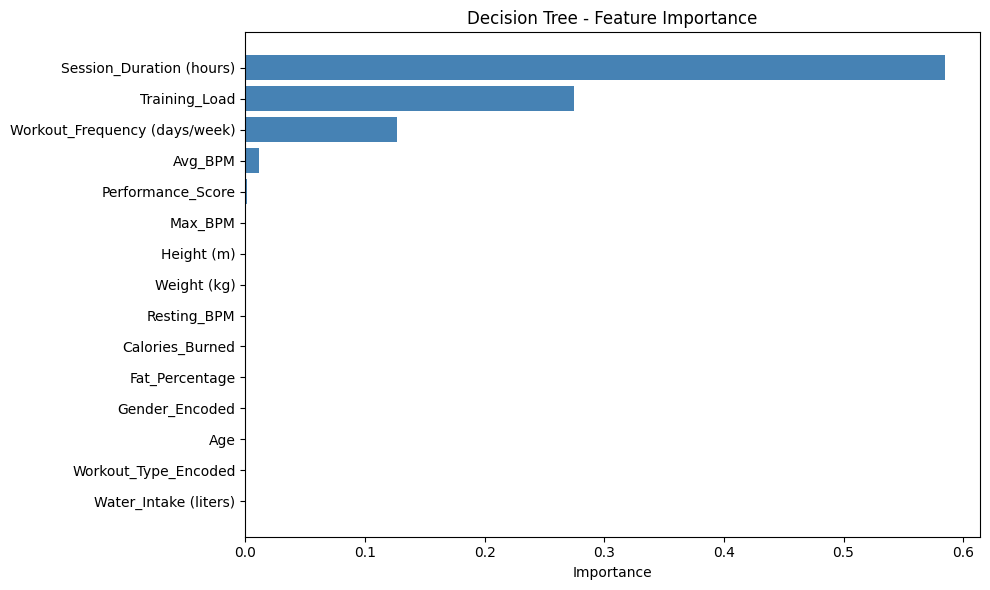

In [13]:
# Feature Importance
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

print('\nTop 10 Önemli Feature:')
print(importance_df.head(10).to_string(index=False))

plt.figure(figsize=(10, 6))
top_15 = importance_df.head(15)
plt.barh(range(len(top_15)), top_15['Importance'], color='steelblue')
plt.yticks(range(len(top_15)), top_15['Feature'])
plt.xlabel('Importance')
plt.title('Decision Tree - Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('dt_exp_feature_importance.png', dpi=150)
plt.show()

In [14]:
# MODEL ÖZETİ
print('\n' + '='*70)
print('MODEL ÖZETİ')
print('='*70)
print(f'Model: Decision Tree')
print(f'Best Params: {grid_search.best_params_}')
print(f'Train Accuracy: {train_acc_best:.4f}')
print(f'Test Accuracy:  {test_acc_best:.4f}')
print(f'CV Mean:        {cv_scores.mean():.4f}')
print('='*70)


MODEL ÖZETİ
Model: Decision Tree
Best Params: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
Train Accuracy: 0.9016
Test Accuracy:  0.9075
CV Mean:        0.8840


DECISION TREE – EXPERIENCE LEVEL PREDICTION
GENEL DEĞERLENDİRME
1) Model Performansı – Genel Bakış
Experience Level tahmini için kullanılan Decision Tree modeli, uygun hiperparametre ayarları ile yüksek doğruluk ve güçlü genelleme performansı sergilemiştir. Başlangıçta herhangi bir kısıtlama olmadan eğitilen Decision Tree modeli, eğitim verisi üzerinde %100 doğruluk elde etmiş ancak test setinde doğruluğun %86.9 seviyesinde kalması nedeniyle aşırı öğrenme (overfitting) eğilimi göstermiştir.
Bu durum, Decision Tree modellerinde derin ve kontrolsüz ağaç yapılarının ezberleme riskini artırdığını açıkça ortaya koymaktadır.
2) Hiperparametre Optimizasyonu ve Overfitting’in Azaltılması
GridSearchCV kullanılarak gerçekleştirilen hiperparametre optimizasyonu sonucunda, ağacın maksimum derinliği 5 ile sınırlandırılmış, minimum yaprak ve bölünme örnek sayıları artırılmıştır. Bu düzenleme sonucunda eğitim doğruluğu %90.2 seviyesine düşerken test doğruluğu %90.8 seviyesine yükselmiştir.
Eğitim ve test doğrulukları arasındaki farkın neredeyse sıfıra inmesi, modelin aşırı öğrenme probleminden büyük ölçüde arındırıldığını ve daha dengeli bir yapı kazandığını göstermektedir.
3) Cross-Validation Sonuçlarının Yorumu
Optimize edilmiş Decision Tree modeli için 5-fold Stratified Cross-Validation uygulanmış ve ortalama doğruluk %88.4 olarak elde edilmiştir. Çapraz doğrulama sonuçlarının test doğruluğu ile uyumlu olması, model performansının belirli bir train-test ayrımına bağlı olmadığını ve istikrarlı şekilde genellenebildiğini göstermektedir.
Bu sonuçlar, Decision Tree modelinin Experience Level değişkenini güvenilir bir biçimde tahmin edebildiğini ortaya koymaktadır.
4) Ağaç Yapısının İncelenmesi ve Yorumlanabilirlik
Karar ağacının ilk seviyeleri incelendiğinde, özellikle Session Duration, Training Load, Workout Frequency ve Avg BPM gibi antrenman yoğunluğunu ve sürekliliğini yansıtan değişkenlerin üst düğümlerde yer aldığı görülmektedir. Bu durum, Decision Tree modelinin karar mekanizmasının fizyolojik ve antrenman temelli mantıklı ayrımlara dayandığını göstermektedir.
Ayrıca, ağaç yapısında kullanılan bu temel bölünmelerin feature importance analizinde öne çıkan değişkenlerle tutarlı olması, modelin kararlarının rastgele değil, anlamlı örüntülere dayandığını doğrulamaktadır.
5) Confusion Matrix ve Sınıf Bazlı Performans
Confusion matrix ve sınıflandırma raporu incelendiğinde, özellikle Advanced sınıfının çok yüksek doğrulukla tahmin edildiği, Intermediate sınıfının ise büyük oranda doğru sınıflandırıldığı görülmektedir. Beginner sınıfında sınırlı sayıda yanlış sınıflandırma bulunsa da genel sınıf dağılımı dengeli şekilde öğrenilmiştir.
Bu durum, modelin yalnızca genel doğruluk açısından değil, sınıf bazlı performans açısından da güvenilir olduğunu göstermektedir.
6) Genel Sonuç ve Model Değerlendirmesi
Sonuç olarak, Decision Tree modeli uygun derinlik kısıtlamaları ve örnek sayısı düzenlemeleri ile optimize edildiğinde, Experience Level tahmini için yüksek doğruluk, güçlü genelleme yeteneği ve yüksek yorumlanabilirlik sunmaktadır. Eğitim, test ve çapraz doğrulama doğruluklarının birbirine yakın olması, modelin aşırı öğrenme yapmadığını ve dengeli bir karar mekanizması geliştirdiğini ortaya koymaktadır.
Bu çalışma, Decision Tree modellerinin doğru şekilde sınırlandırıldığında hem güçlü hem de açıklanabilir sonuçlar üretebildiğini göstermekte ve Experience Level tahmini için etkili bir yaklaşım sunduğunu ortaya koymaktadır.